In [36]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools
import pdb

In [37]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [38]:
def list_itr(netname):
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    f = _FILEDIR_ + '/' + _FILEMAP_[netname]
    itr_v = [int(f.rstrip('.csv').split('_')[-1]) for f in commands.getoutput('ls %s*csv' % f).split() if f.endswith('csv')]
    itr_v.sort()
    return itr_v

def get_df(netname,itr):
    key=(netname,itr)
    if key in _DATAMAP_:
        return _DATAMAP_[key]
    
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    
    itr_v = list_itr(netname)
    if not itr in itr_v:
        print 'Iteration',itr,'not found'
        return None

    f = _FILEDIR_ + '/' + _FILEMAP_[netname] + str(itr) + '.csv'
    if not os.path.isfile(f):
        print 'LOGIC ERROR ... file not found (should not happen):',f
        return None
    
    df = pd.read_csv(f)
    _DATAMAP_[key] = df
    return _DATAMAP_[key]

def get_accuracy(netname,labels,names):
    if not len(labels) == len(names):
        print '# labels and # names do not match...'
        return None
    for label in labels:
        if not type(label) == type(list()):
            print 'Labels must be of list type'
            return None
        
    # Report available list of iterations
    itr_v = list_itr(netname)
    print 'Iterations',itr_v
    print

    res = {'all_combined':[]}
    for name in names:
        res[name] = []

    # Loop over iterations and print accuracy
    for itr in itr_v:
        # Get data frame
        df = get_df(netname,itr)

        # Compute overall accuracy
        numerator = ''
        for label in labels:
            if numerator: numerator += ' or '
            numerator += '((label in %s) and (prediction in %s))' % (str(label),str(label))
        denominator = ''
        for label in labels:
            if denominator: denominator += ' or '
            denominator += '(label in %s)' % str(label)

        total = float(len(df.query(denominator)))
        acc = 0.
        if total > 0.:
            acc = len(df.query(numerator)) / total
        acc = int(acc*10000)/100.
        res['all_combined'].append(acc)

        # compute per-label accuracy
        for idx in xrange(len(labels)):
            label = labels[idx]
            name  = str(names[idx])
            numerator   = '((label in %s) and (prediction in %s))' % (str(label),str(label))
            denominator = '(label in %s)' % str(label)
            total = float(len(df.query(denominator)))
            acc = 0.
            if total >= 1.:
                acc = len(df.query(numerator)) / total
            acc = int(acc*10000/100.)
            res[name].append(acc)
    
    res['Iteration'] = itr_v
    res = pd.DataFrame(res)
    return res

Network vgg16c

Iterations [215000, 215250, 215500, 215750, 216000, 216250, 216500, 216750, 217000, 217250, 217500, 217750, 218000, 218250, 218500, 218750, 219000, 219250, 219500, 219750, 220000, 220250, 220500, 220750, 221000, 221250, 221500, 221750]

Result:
    Iteration  all_combined  eminus  eminus_ctr  gamma  gamma_ctr  muminus  \
0      215000         87.89   86.48      2500.0  88.20     2500.0    88.44   
1      215250         87.79   87.68      2500.0  88.28     2500.0    94.72   
2      215500         87.92   86.92      2500.0  87.48     2500.0    90.72   
3      215750         87.82   89.00      2500.0  83.84     2500.0    91.44   
4      216000         86.65   90.64      2500.0  83.64     2500.0    81.00   
5      216250         87.65   84.92      2500.0  89.52     2500.0    94.32   
6      216500         87.56   86.64      2500.0  86.24     2500.0    94.04   
7      216750         87.22   87.64      2500.0  83.40     2500.0    89.20   
8      217000         87.56   90.32  

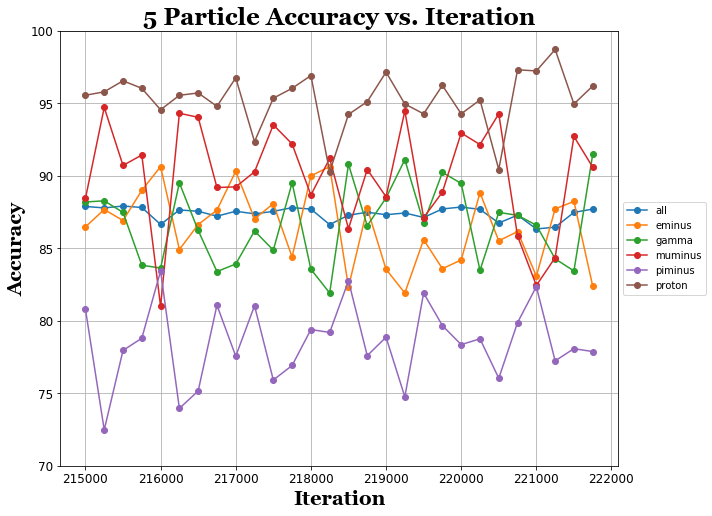

In [39]:
#
# Analysis: try printing accuracy per iteration
#

#
# Configurations
#
# network name
netname='vgg16c'

# Report network name
print 'Network',netname
print

# Report available list of iterations
itr_v = list_itr(netname)
print 'Iterations',itr_v
print

res={'all_combined':[]}
for l in _LABELS_:
    res[l]=[]
    res['%s_ctr' % l]=[]

# Loop over iterations and print accuracy
for itr in itr_v:
    # Get data frame
    df = get_df(netname,itr)

    # Compute overall accuracy
    acc = len(df.query('label==prediction')) / float(len(df))
    acc = int(acc*10000)/100.
    res['all_combined'].append(acc)
    
    # Compute per-particle accuracy
    for idx in xrange(len(_LABELS_)):
        label = _LABELS_[idx]
        total = float(len(df.query('label==%d' % idx)))
        res['%s_ctr' % label].append(total)
        
        if total<1.:
            res[label].append(0.)
        else:
            acc = len(df.query('label==prediction and label==%d' % idx)) / total
            acc = int(acc*10000)/100.
            res[label].append(acc)

res['Iteration'] = itr_v
res = pd.DataFrame(res)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')
plt.plot(res.Iteration.values,res.eminus.values,label='eminus',marker='o')
plt.plot(res.Iteration.values,res.gamma.values,label='gamma',marker='o')
plt.plot(res.Iteration.values,res.muminus.values,label='muminus',marker='o')
plt.plot(res.Iteration.values,res.piminus.values,label='piminus',marker='o')
plt.plot(res.Iteration.values,res.proton.values,label='proton',marker='o')

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
plt.savefig("part5_vggc.png")

Network vgg16c

Iterations [215000, 215250, 215500, 215750, 216000, 216250, 216500, 216750, 217000, 217250, 217500, 217750, 218000, 218250, 218500, 218750, 219000, 219250, 219500, 219750, 220000, 220250, 220500, 220750, 221000, 221250, 221500, 221750]

Result:
    Iteration  all_combined  shower  track
0      215000         99.15      99     99
1      215250         99.14      99     99
2      215500         99.12      99     99
3      215750         98.78      97     99
4      216000         99.08      98     99
5      216250         99.16      99     99
6      216500         98.87      97     99
7      216750         98.91      98     99
8      217000         99.12      99     99
9      217250         99.08      98     99
10     217500         98.88      98     99
11     217750         99.04      98     99
12     218000         98.96      98     99
13     218250         99.12      99     99
14     218500         99.08      98     99
15     218750         99.04      99     98
16     2

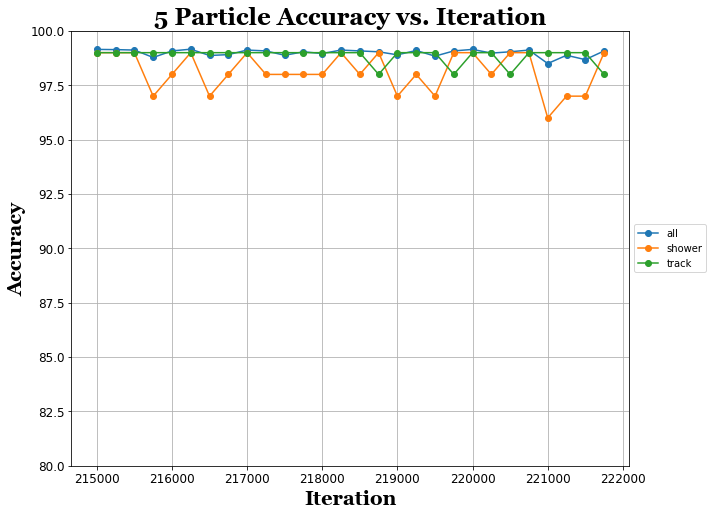

In [40]:
#
# Analyze shower/track
#

#
# Configurations
#
# network name
netname='vgg16c'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['shower','track']
labels = [[0,1], [2,3,4]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(80,100)
#plt.show()
plt.savefig("part_show-trk_vggc.png")

Network vgg16c

Iterations [215000, 215250, 215500, 215750, 216000, 216250, 216500, 216750, 217000, 217250, 217500, 217750, 218000, 218250, 218500, 218750, 219000, 219250, 219500, 219750, 220000, 220250, 220500, 220750, 221000, 221250, 221500, 221750]

Result:
    Iteration  all_combined  eminus  gamma
0      215000         87.34      86     88
1      215250         87.98      87     88
2      215500         87.20      86     87
3      215750         86.42      89     83
4      216000         87.14      90     83
5      216250         87.22      84     89
6      216500         86.44      86     86
7      216750         85.52      87     83
8      217000         87.12      90     83
9      217250         86.62      87     86
10     217500         86.48      88     84
11     217750         86.96      84     89
12     218000         86.78      90     83
13     218250         86.28      90     81
14     218500         86.56      82     90
15     218750         87.16      87     86
16     2

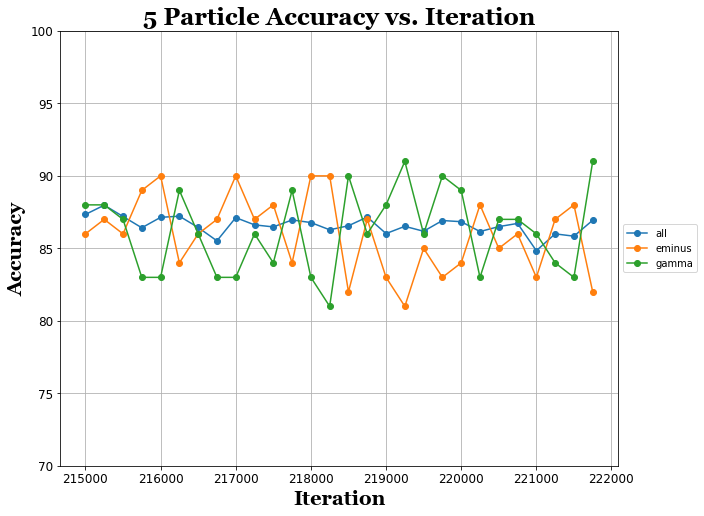

In [41]:
#
# Analyze e/gamma
#

#
# Configurations
#
# network name
netname='vgg16c'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['eminus','gamma']
labels = [[0], [1]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
#plt.show()
plt.savefig("part_e-gamma_vggc.png")

Network vgg16c

Iterations [215000, 215250, 215500, 215750, 216000, 216250, 216500, 216750, 217000, 217250, 217500, 217750, 218000, 218250, 218500, 218750, 219000, 219250, 219500, 219750, 220000, 220250, 220500, 220750, 221000, 221250, 221500, 221750]

Result:
    Iteration  all_combined  muminus  piminus
0      215000         84.62       88       80
1      215250         83.60       94       72
2      215500         84.34       90       77
3      215750         85.12       91       78
4      216000         82.22       81       83
5      216250         84.14       94       73
6      216500         84.60       94       75
7      216750         85.14       89       81
8      217000         83.40       89       77
9      217250         85.66       90       81
10     217500         84.72       93       75
11     217750         84.56       92       76
12     218000         84.04       88       79
13     218250         85.20       91       79
14     218500         84.56       86       82
15 

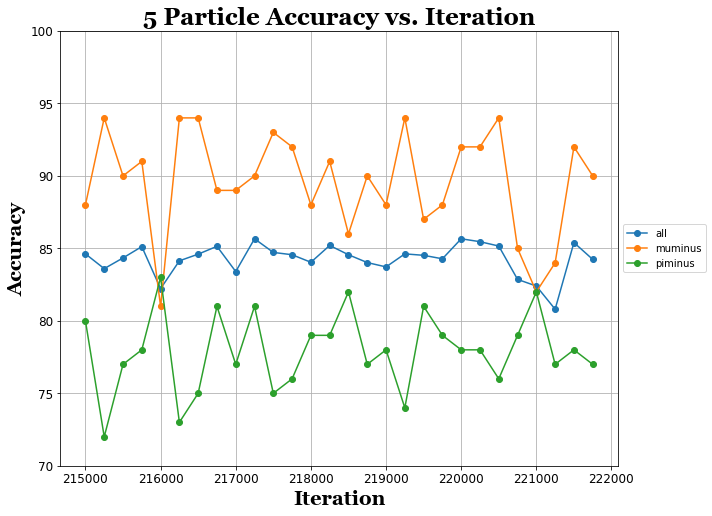

In [42]:
#
# Analyze mu/pi
#

#
# Configurations
#
# network name
netname='vgg16c'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['muminus','piminus']
labels = [[2], [3]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
#plt.show()
plt.savefig("part_mu-pi_vggc.png")